# Pandas 2.0 Guide

## How to install this Pandas version?
You can get the release notes of this version(s) [here](https://pandas.pydata.org/docs/dev/whatsnew/index.html#release). You can also the released versions [here](https://github.com/pandas-dev/pandas/releases). Run the below pip command to install the version `2.0.0`

```bash
pip install --upgrade --pre "pandas[hdf5, parquet, feather, spss, excel]==2.0.0rc1"
```

In [1]:
import numpy as np
import pandas as pd
import polars as pl  # pip install polars

In [2]:
print(f"Pandas => {pd.__version__}")
print(f"Polars => {pl.__version__}")
print(f"Numpy => {np.__version__}")

Pandas => 2.0.0rc1
Polars => 0.16.14
Numpy => 1.23.5


## Basic Use

In [3]:
# load a dummy dataset
# https://raw.githubusercontent.com/hadley/data-baby-names/master/baby-names.csv
df = pd.read_csv("baby_names.csv")
df.head()

,year,name,percent,sex
0,1880,John,0.081541,boy
1,1880,William,0.080511,boy
2,1880,James,0.050057,boy
3,1880,Charles,0.045167,boy
4,1880,George,0.043292,boy


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258000 entries, 0 to 257999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     258000 non-null  int64  
 1   name     258000 non-null  object 
 2   percent  258000 non-null  float64
 3   sex      258000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 7.9+ MB


In [5]:
# You can see that by-default Pandas uses NumPy as backend

print(type(df["percent"].values))
df["percent"].values

<class 'numpy.ndarray'>


array([0.081541, 0.080511, 0.050057, ..., 0.000127, 0.000127, 0.000127])

In [6]:
# Using arrow as backend in Pandas
pd.Series([1, 2, 3, 4], dtype="int64[pyarrow]")

0    1
1    2
2    3
3    4
dtype: int64[pyarrow]

In [7]:
# similarly you can use arrow as backend for strings
pd.Series(["a", "b", "c", "d"], dtype="string[pyarrow]")

0    a
1    b
2    c
3    d
dtype: string

In [8]:
# you can set Pandas to use arrow as backend as default
pd.options.mode.dtype_backend = "pyarrow"

In [9]:
# now read the same csv file again
df_arrow = pd.read_csv("baby_names.csv", engine="pyarrow", use_nullable_dtypes=True)

In [10]:
df_arrow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258000 entries, 0 to 257999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype          
---  ------   --------------   -----          
 0   year     258000 non-null  int64[pyarrow] 
 1   name     258000 non-null  string[pyarrow]
 2   percent  258000 non-null  double[pyarrow]
 3   sex      258000 non-null  string[pyarrow]
dtypes: double[pyarrow](1), int64[pyarrow](1), string[pyarrow](2)
memory usage: 8.2 MB


## Advantages

### Advantage 1: Can handle the missing values in better way

In [13]:
# Old way of creating a Series with missing values
pd.Series([1, 2, 3, 4, None])

0    1.0
1    2.0
2    3.0
3    4.0
4    NaN
dtype: float64

In [14]:
# New way of creating a Series with missing values
pd.Series([1, 2, 3, 4, None], dtype="int64[pyarrow]")

0       1
1       2
2       3
3       4
4    <NA>
dtype: int64[pyarrow]

### Advantage 2: Arrow backend is much faster than the previous version

In [15]:
# old way
%timeit df["percent"].mean()

395 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
# new way
%timeit df_arrow["percent"].mean()

207 µs ± 6.86 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
395/207

1.9082125603864735

In [18]:
# reading in the data numpy backend
%timeit df = pd.read_csv("baby_names.csv")

83.7 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
# reading in the data arrow backend
%timeit df_arrow = pd.read_csv("baby_names.csv", engine="pyarrow", use_nullable_dtypes=True)

16.4 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
83.7/16.4

5.103658536585367

### Advantage 3: String operations are much faster

In [21]:
df["name"]

0             John
1          William
2            James
3          Charles
4           George
            ...   
257995    Carleigh
257996       Iyana
257997      Kenley
257998      Sloane
257999     Elianna
Name: name, Length: 258000, dtype: object

In [22]:
%timeit df["name"].str.startswith("A")

59.1 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit df_arrow["name"].str.startswith("A")

1.31 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
60/1.3

46.15384615384615

## Interoperability

Apache Arrow is used by more than just Pandas:
- R
- Spark
- Polars

In [25]:
print("polars =>", pl.__version__)

polars => 0.16.14


In [26]:
df_arrow = pd.read_csv("baby_names.csv", engine="pyarrow", use_nullable_dtypes=True)

<Axes: title={'center': 'Top 10 baby names'}, ylabel='name'>

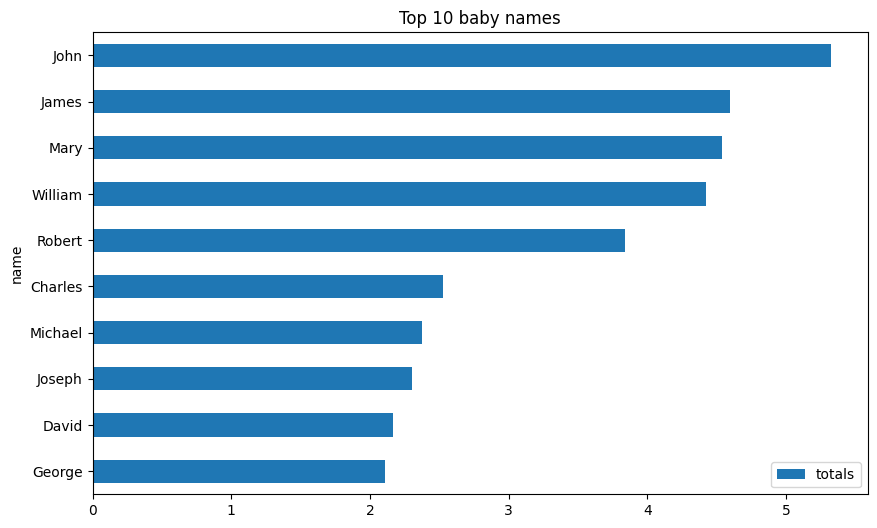

In [34]:
# Convert Pandas DataFrame to Polars DataFrame
df_polars = pl.from_pandas(df_arrow)
# Do GroupBy operations on the Polars DataFrame
agg_polars = (
    df_polars.groupby("name")
    .agg(pl.col(['percent'])
    .sum().alias('totals'))
)
# Convert Polars DataFrame to Pandas DataFrame
agg_pandas = agg_polars.to_pandas()
# Plot the Pandas DataFrame
agg_pandas.set_index("name")\
    .sort_values("totals", ascending=False)\
    .head(10)\
    .sort_values("totals")\
    .plot(kind="barh", figsize=(10, 6), title="Top 10 baby names")

## Apache Arrow Data Types

In [36]:
pd.Series([True, False, True], dtype="bool[pyarrow]").info()

<class 'pandas.core.series.Series'>
RangeIndex: 3 entries, 0 to 2
Series name: None
Non-Null Count  Dtype        
--------------  -----        
3 non-null      bool[pyarrow]
dtypes: bool[pyarrow](1)
memory usage: 129.0 bytes


In [37]:
pd.Series([True, False, True]).info()

<class 'pandas.core.series.Series'>
RangeIndex: 3 entries, 0 to 2
Series name: None
Non-Null Count  Dtype
--------------  -----
3 non-null      bool 
dtypes: bool(1)
memory usage: 131.0 bytes
